In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import cv2
import json
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms_v2
from tqdm import tqdm
import time

# Set random seed for reproducibility
random.seed(42)

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Set paths
image_dir = 'chessred2k'  # Adjust this path as needed
annotations_file = os.path.join('chessred2k', 'annotations.json')  # Adjust this path as needed

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle/input')
if is_kaggle:
    # Kaggle paths
    root_dir = '/kaggle/input/chessred'
    annotations_file = os.path.join(root_dir, 'annotations.json')
    image_dir = os.path.join(root_dir, 'chessred2k')

Using cuda device


In [26]:
def chesspos2number(chesspos):
    """Convert chess position (e.g., 'a1') to zero-indexed row and column"""
    col = ord(chesspos[0]) - ord('a')
    row = int(chesspos[1]) - 1
    return row, col

class ChessDatasetWithBBoxes(Dataset):
    """Chess dataset that uses the actual bounding boxes from annotations"""
    
    def __init__(self, image_dir, annotations_file, partition='train', transform=None):
        """
        Initialize the dataset with actual bounding box annotations.
        
        Args:
            image_dir: Directory containing the dataset images
            annotations_file: Path to annotations.json file
            partition: 'train', 'valid' or 'test'
            transform: Optional transforms to apply to images
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Load annotations
        print(f"Loading annotations from {annotations_file}")
        self.anns = json.load(open(annotations_file))
        self.categories = [c['name'] for c in self.anns['categories']]
        
        # Map category IDs to names for easier reference
        self.category_map = {}
        for cat in self.anns['categories']:
            self.category_map[cat['id']] = cat['name']
        
        # Load image information
        self.ids = []
        self.file_names = []
        for img in self.anns['images']:
            self.file_names.append(img['path'])
            self.ids.append(img['id'])
        
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Initialize board state
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        
        # Create a mapping from image ID to annotations and corners
        self.img_to_annots = {img_id: [] for img_id in self.ids}
        self.img_to_corners = {img_id: None for img_id in self.ids}
        
        # Process piece annotations with bounding boxes
        for piece in self.anns['annotations']['pieces']:
            img_id = piece['image_id']
            idx = np.where(self.ids == img_id)[0][0]
            
            # Record board position
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1
            
            # Store the annotation with the image
            if 'bbox' in piece:
                self.img_to_annots[img_id].append({
                    'bbox': piece['bbox'],
                    'category_id': piece['category_id'],
                    'position': piece['chessboard_position']
                })
        
        # Process corner annotations
        for corner in self.anns['annotations']['corners']:
            img_id = corner['image_id']
            self.img_to_corners[img_id] = corner['corners']
        
        # Get the split indices for the specified partition
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)
        
        # Filter data based on split
        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]
        
        # Count pieces for each image
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        
        print(f"Number of {partition} images: {len(self.file_names)}")
        
        # Print piece count statistics
        piece_counts = self.num_pieces.numpy().astype(int)
        print(f"Piece count statistics - min: {np.min(piece_counts)}, max: {np.max(piece_counts)}, mean: {np.mean(piece_counts):.2f}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        try:
            # Get image path
            image_path = os.path.join(self.image_dir, self.file_names[i])
            
            # Load image
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                image = np.zeros((640, 640, 3), dtype=np.uint8)
            else:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    image = np.zeros((640, 640, 3), dtype=np.uint8)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Get annotations for this image
            img_id = self.ids[i]
            annotations = self.img_to_annots[img_id]
            corners = self.img_to_corners[img_id]
            
            # Count pieces from board state
            num_pieces = int(self.num_pieces[i].item())
            
            # Get original image dimensions for normalization
            original_h, original_w = image.shape[:2]
            
            # Apply transform to image if specified
            if self.transform:
                image = self.transform(image)
            
            return image, num_pieces, annotations, corners, (original_h, original_w), image_path
            
        except Exception as e:
            print(f"Error loading image {i}: {str(e)}")
            # Return placeholder if there's an error
            return np.zeros((640, 640, 3), dtype=np.uint8), 0, [], None, (0, 0), ""

In [27]:
# Create dataset instances using the paths
train_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='train'
)

valid_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='valid'
)

test_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='test'
)

Loading annotations from /kaggle/input/chessred/annotations.json
Number of train images: 1442
Piece count statistics - min: 8, max: 32, mean: 21.31
Loading annotations from /kaggle/input/chessred/annotations.json
Number of valid images: 330
Piece count statistics - min: 6, max: 32, mean: 18.58
Loading annotations from /kaggle/input/chessred/annotations.json
Number of test images: 306
Piece count statistics - min: 6, max: 32, mean: 20.57


In [28]:
# Import additional libraries for ResNet implementation
import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as transforms_v2

# Create transforms for ResNet50
data_transforms = {
    'train': transforms_v2.Compose([
        transforms_v2.ToImage(),
        transforms_v2.Resize((256, 256)),
        transforms_v2.RandomCrop((224, 224)),
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms_v2.Compose([
        transforms_v2.ToImage(),
        transforms_v2.Resize((256, 256)),
        transforms_v2.CenterCrop((224, 224)),
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms_v2.Compose([
        transforms_v2.ToImage(),
        transforms_v2.Resize((256, 256)),
        transforms_v2.CenterCrop((224, 224)),
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [29]:
class ChessDatasetResNet(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, count, _, _, _, _ = self.base_dataset[idx]
        
        # Apply transforms if provided
        if self.transform:
            # Convert numpy array to PIL Image for torchvision transforms
            if isinstance(img, np.ndarray):
                img = self.transform(img)
        
        # Return image and count as a float tensor for regression
        return img, torch.tensor([float(count)]).float()

# Create ResNet-ready datasets
train_dataset_resnet = ChessDatasetResNet(train_dataset, transform=data_transforms['train'])
valid_dataset_resnet = ChessDatasetResNet(valid_dataset, transform=data_transforms['valid'])
test_dataset_resnet = ChessDatasetResNet(test_dataset, transform=data_transforms['test'])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_resnet, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_resnet, batch_size=batch_size, shuffle=False)

# Check a batch
for images, counts in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Counts shape: {counts.shape}")
    print(f"Sample counts: {counts[:5].squeeze().numpy()}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Counts shape: torch.Size([32, 1])
Sample counts: [25. 28. 32. 32. 14.]


In [30]:
class PieceCountRegressor(nn.Module):
    def __init__(self, freeze_backbone=False):
        super(PieceCountRegressor, self).__init__()
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False
        
        # Get number of features from the last layer
        num_features = self.resnet.fc.in_features
        
        # Replace the final classification layer with regression layers
        # For regression:
        # - Single output neuron (1) instead of multiple classes
        # - No softmax activation at the end
        # - Optional ReLU to ensure counts are positive
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Single output for regression
            nn.ReLU()  # Ensure non-negative outputs (piece count is always positive)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model
model = PieceCountRegressor(freeze_backbone=True)  # Start with frozen backbone
model = model.to(device)
print(model)

PieceCountRegressor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [31]:
# Define loss function for regression - Mean Squared Error
# For regression problems, we typically use:
# - MSE: Mean Squared Error (penalizes larger errors more)
# - MAE: Mean Absolute Error (more robust to outliers)
# - Huber: Combination of MSE and MAE
loss_fn = nn.MSELoss()

# Define optimizer - Adam with learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

In [32]:
def train_step(dataloader, model, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    for images, targets in tqdm(dataloader, desc="Training"):
        # Move data to device
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        running_mae += torch.sum(torch.abs(outputs - targets)).item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_mae = running_mae / len(dataloader.dataset)
    
    return epoch_loss, epoch_mae

def valid_step(dataloader, model, loss_fn):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            
            # Track metrics
            running_loss += loss.item() * images.size(0)
            running_mae += torch.sum(torch.abs(outputs - targets)).item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_mae = running_mae / len(dataloader.dataset)
    
    return epoch_loss, epoch_mae

In [33]:
# Training parameters
num_epochs = 30
best_val_loss = float('inf')
best_model_path = 'best_piece_counter_resnet50.pt'

# History for plotting
train_history = {'loss': [], 'mae': []}
valid_history = {'loss': [], 'mae': []}

# Train the model
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_mae = train_step(train_loader, model, loss_fn, optimizer)
    train_history['loss'].append(train_loss)
    train_history['mae'].append(train_mae)
    
    # Validate
    val_loss, val_mae = valid_step(valid_loader, model, loss_fn)
    valid_history['loss'].append(val_loss)
    valid_history['mae'].append(val_mae)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Valid Loss: {val_loss:.4f}, Valid MAE: {val_mae:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with validation loss: {val_loss:.4f}")
    
    # Unfreeze backbone after 5 epochs of training the head
    if epoch == 5:
        print("Unfreezing backbone layers...")
        for param in model.resnet.parameters():
            param.requires_grad = True
        # Adjust learning rate for full model training
        optimizer = torch.optim.Adam([
            {'params': model.resnet.fc.parameters()},
            {'params': list(set(model.parameters()) - set(model.resnet.fc.parameters())), 'lr': 0.0001}
        ], lr=0.001)


Epoch 1/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.52s/it]


Train Loss: 212.6206, Train MAE: 11.9421
Valid Loss: 90.4621, Valid MAE: 7.9609
Saved best model with validation loss: 90.4621

Epoch 2/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 65.8496, Train MAE: 6.6759
Valid Loss: 69.7645, Valid MAE: 7.0868
Saved best model with validation loss: 69.7645

Epoch 3/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 47.3475, Train MAE: 5.5814
Valid Loss: 48.9451, Valid MAE: 5.8837
Saved best model with validation loss: 48.9451

Epoch 4/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Train Loss: 37.8993, Train MAE: 4.9805
Valid Loss: 43.4532, Valid MAE: 5.3523
Saved best model with validation loss: 43.4532

Epoch 5/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Train Loss: 29.8999, Train MAE: 4.3816
Valid Loss: 27.1326, Valid MAE: 4.2338
Saved best model with validation loss: 27.1326

Epoch 6/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.40s/it]


Train Loss: 22.3982, Train MAE: 3.7251
Valid Loss: 19.8991, Valid MAE: 3.5883
Saved best model with validation loss: 19.8991
Unfreezing backbone layers...

Epoch 7/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Train Loss: 16.1371, Train MAE: 3.1692
Valid Loss: 8.0605, Valid MAE: 2.2588
Saved best model with validation loss: 8.0605

Epoch 8/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Train Loss: 8.4661, Train MAE: 2.2964
Valid Loss: 6.4212, Valid MAE: 2.0089
Saved best model with validation loss: 6.4212

Epoch 9/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Train Loss: 7.8096, Train MAE: 2.2151
Valid Loss: 6.5208, Valid MAE: 2.0301

Epoch 10/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Train Loss: 5.4913, Train MAE: 1.8863
Valid Loss: 5.7521, Valid MAE: 1.8843
Saved best model with validation loss: 5.7521

Epoch 11/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Train Loss: 7.8679, Train MAE: 2.2153
Valid Loss: 5.0409, Valid MAE: 1.7840
Saved best model with validation loss: 5.0409

Epoch 12/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Train Loss: 5.3991, Train MAE: 1.8342
Valid Loss: 3.9684, Valid MAE: 1.5724
Saved best model with validation loss: 3.9684

Epoch 13/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


Train Loss: 5.0541, Train MAE: 1.7676
Valid Loss: 4.3776, Valid MAE: 1.5998

Epoch 14/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.50s/it]


Train Loss: 4.4210, Train MAE: 1.6644
Valid Loss: 3.6788, Valid MAE: 1.4758
Saved best model with validation loss: 3.6788

Epoch 15/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Train Loss: 4.5857, Train MAE: 1.6862
Valid Loss: 3.3382, Valid MAE: 1.4632
Saved best model with validation loss: 3.3382

Epoch 16/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


Train Loss: 3.7891, Train MAE: 1.5118
Valid Loss: 3.4766, Valid MAE: 1.4807

Epoch 17/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 3.9424, Train MAE: 1.5564
Valid Loss: 3.5295, Valid MAE: 1.5199

Epoch 18/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 4.9189, Train MAE: 1.7461
Valid Loss: 6.7214, Valid MAE: 2.1300

Epoch 19/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Train Loss: 4.5111, Train MAE: 1.6606
Valid Loss: 4.0611, Valid MAE: 1.6102

Epoch 20/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 3.3590, Train MAE: 1.4227
Valid Loss: 3.1959, Valid MAE: 1.3765
Saved best model with validation loss: 3.1959

Epoch 21/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Train Loss: 4.0329, Train MAE: 1.5882
Valid Loss: 3.9201, Valid MAE: 1.5148

Epoch 22/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Train Loss: 4.6448, Train MAE: 1.6881
Valid Loss: 4.1675, Valid MAE: 1.6505

Epoch 23/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Train Loss: 3.8296, Train MAE: 1.5530
Valid Loss: 4.8827, Valid MAE: 1.7752

Epoch 24/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Train Loss: 3.3605, Train MAE: 1.4307
Valid Loss: 2.7142, Valid MAE: 1.3126
Saved best model with validation loss: 2.7142

Epoch 25/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Train Loss: 3.0784, Train MAE: 1.3718
Valid Loss: 3.5641, Valid MAE: 1.5834

Epoch 26/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Train Loss: 3.4104, Train MAE: 1.4556
Valid Loss: 2.6873, Valid MAE: 1.2705
Saved best model with validation loss: 2.6873

Epoch 27/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Train Loss: 3.2815, Train MAE: 1.3929
Valid Loss: 2.4391, Valid MAE: 1.2546
Saved best model with validation loss: 2.4391

Epoch 28/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Train Loss: 3.7331, Train MAE: 1.5196
Valid Loss: 2.6669, Valid MAE: 1.3214

Epoch 29/30


Validation: 100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Train Loss: 2.8922, Train MAE: 1.3339
Valid Loss: 2.4289, Valid MAE: 1.2088
Saved best model with validation loss: 2.4289

Epoch 30/30


Validation: 100%|██████████| 11/11 [00:49<00:00,  4.47s/it]

Train Loss: 2.7514, Train MAE: 1.3129
Valid Loss: 3.5926, Valid MAE: 1.4567


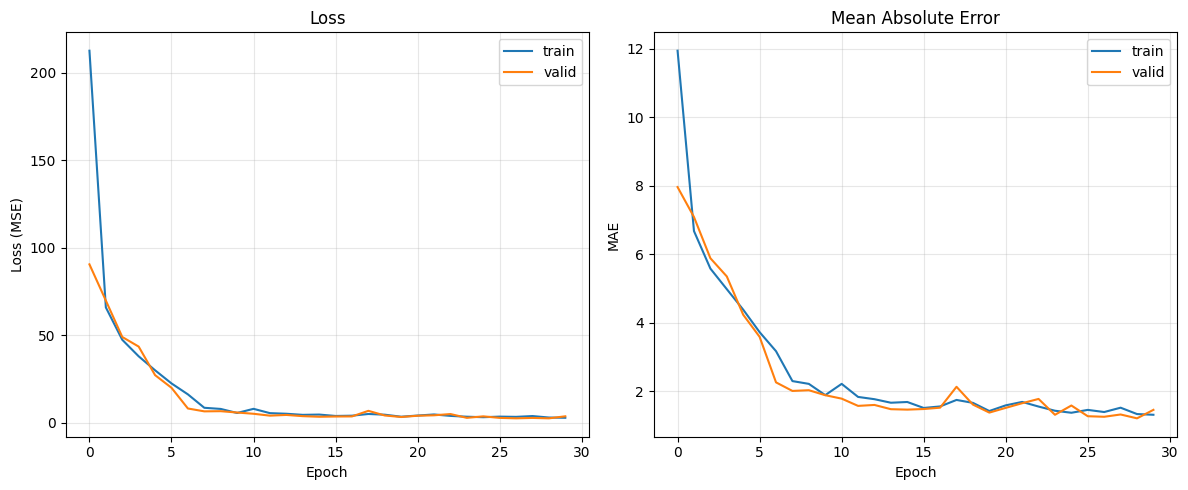

In [34]:
def plot_training_history(train_history, valid_history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(valid_history['loss'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.title('Mean Absolute Error')
    plt.plot(train_history['mae'], label='train')
    plt.plot(valid_history['mae'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(train_history, valid_history)

Testing: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Test Results:
Mean Absolute Error (MAE): 1.1895
Root Mean Square Error (RMSE): 1.5635
Accuracy (exact matches after rounding): 0.2549 (78/306)


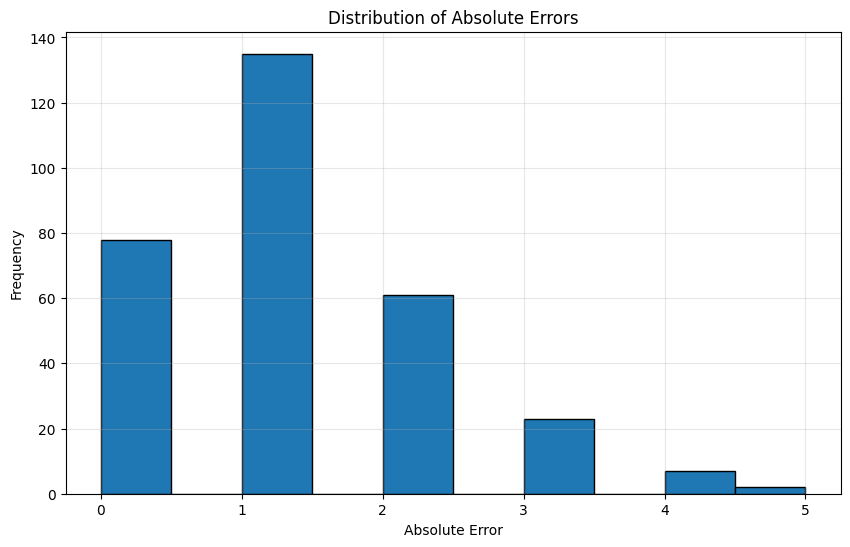

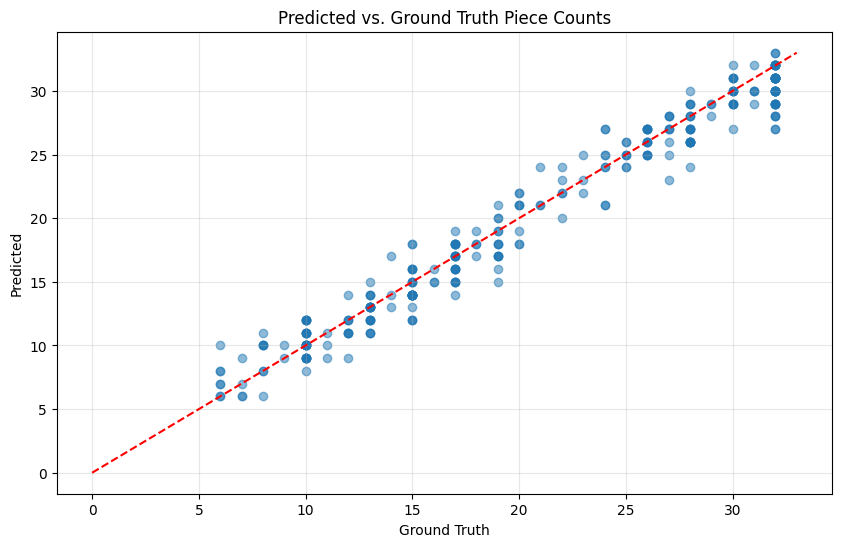

In [35]:
def evaluate_model(model_path, test_loader):
    # Load best model
    model = PieceCountRegressor()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Initialize metrics
    results = {
        'predictions': [],
        'ground_truth': [],
        'absolute_errors': [],
        'squared_errors': [],
        'correct_count': 0,
    }
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Testing"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Round predictions to nearest integer for counting
            preds = torch.round(outputs)
            
            # Get exact matches (after rounding)
            exact_matches = (preds == targets).sum().item()
            results['correct_count'] += exact_matches
            
            # Add batch results to overall metrics
            results['predictions'].extend(preds.cpu().numpy().flatten().tolist())
            results['ground_truth'].extend(targets.cpu().numpy().flatten().tolist())
            
            # Calculate errors
            abs_errors = torch.abs(preds - targets).cpu().numpy().flatten().tolist()
            sq_errors = ((preds - targets) ** 2).cpu().numpy().flatten().tolist()
            
            results['absolute_errors'].extend(abs_errors)
            results['squared_errors'].extend(sq_errors)
    
    # Calculate metrics
    mae = np.mean(results['absolute_errors'])
    mse = np.mean(results['squared_errors'])
    rmse = np.sqrt(mse)
    
    # Calculate accuracy (exact matches after rounding)
    accuracy = results['correct_count'] / len(test_loader.dataset)
    
    print(f"\nTest Results:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"Accuracy (exact matches after rounding): {accuracy:.4f} ({results['correct_count']}/{len(test_loader.dataset)})")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(results['absolute_errors'], bins=10, edgecolor='black')
    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.scatter(results['ground_truth'], results['predictions'], alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(results['ground_truth']), max(results['predictions']))
    plt.plot([0, max_val], [0, max_val], 'r--')
    
    plt.title('Predicted vs. Ground Truth Piece Counts')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Evaluate the best model
if os.path.exists(best_model_path):
    test_results = evaluate_model(best_model_path, test_loader)
else:
    print("No model available for evaluation. Please train the model first.")

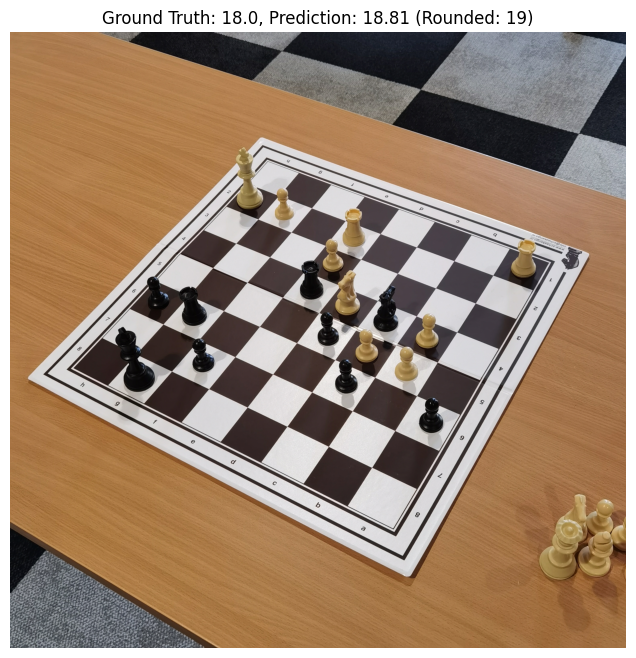

Image: /kaggle/input/chessred/chessred2k/images/0/G000_IMG057.jpg
Ground Truth: 18.0
Prediction: 18.81 (Rounded: 19)
Absolute Error: 0.81
--------------------------------------------------


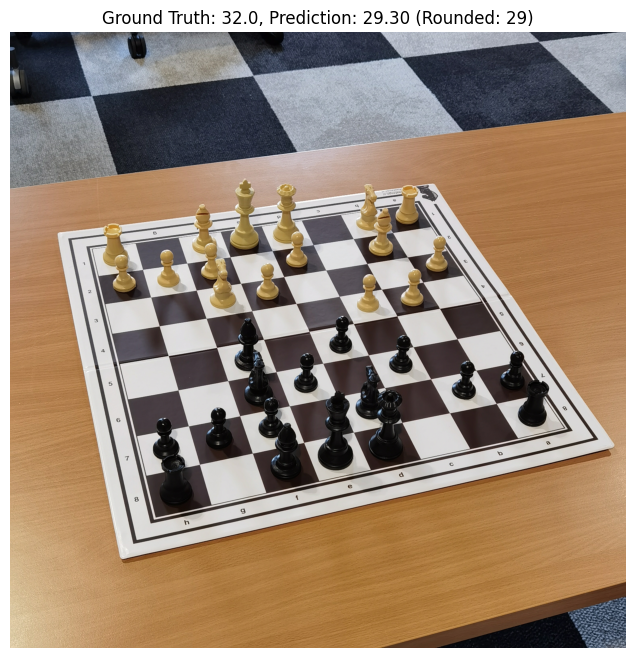

Image: /kaggle/input/chessred/chessred2k/images/0/G000_IMG012.jpg
Ground Truth: 32.0
Prediction: 29.30 (Rounded: 29)
Absolute Error: 2.70
--------------------------------------------------


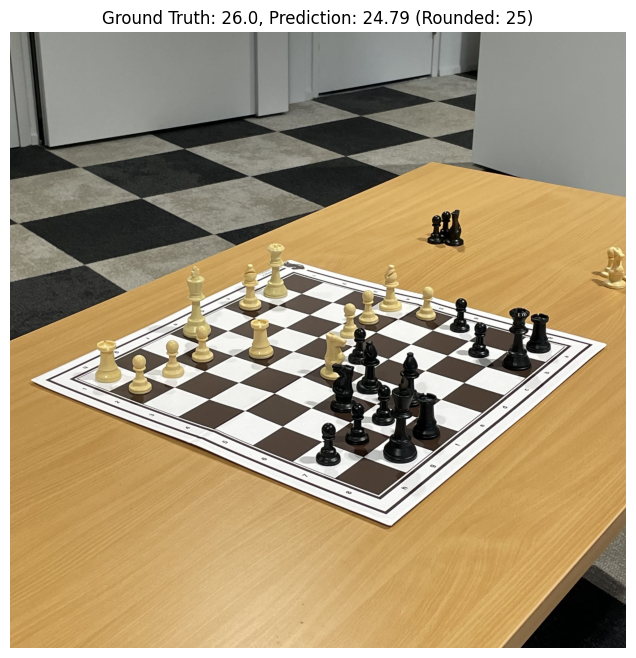

Image: /kaggle/input/chessred/chessred2k/images/33/G033_IMG037.jpg
Ground Truth: 26.0
Prediction: 24.79 (Rounded: 25)
Absolute Error: 1.21
--------------------------------------------------


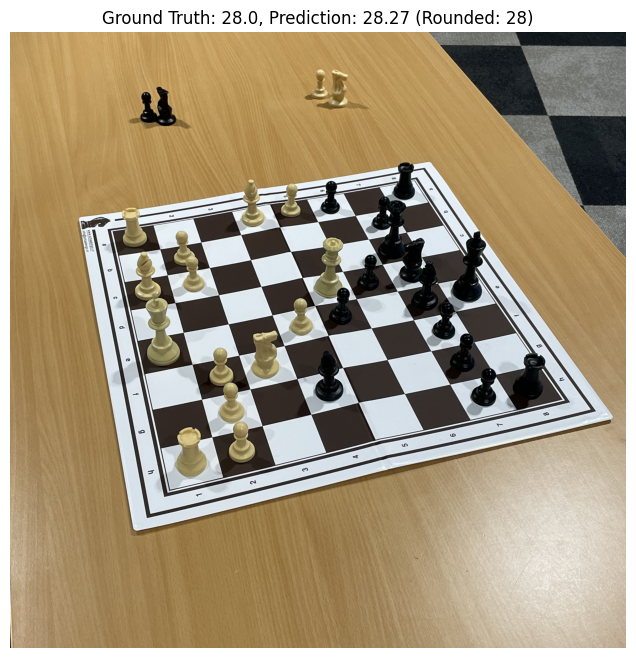

Image: /kaggle/input/chessred/chessred2k/images/33/G033_IMG022.jpg
Ground Truth: 28.0
Prediction: 28.27 (Rounded: 28)
Absolute Error: 0.27
--------------------------------------------------


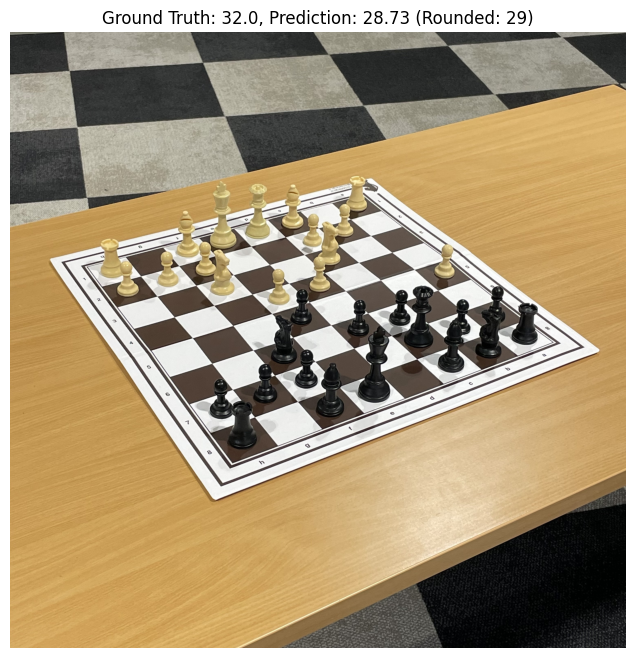

Image: /kaggle/input/chessred/chessred2k/images/33/G033_IMG011.jpg
Ground Truth: 32.0
Prediction: 28.73 (Rounded: 29)
Absolute Error: 3.27
--------------------------------------------------


In [36]:
def visualize_predictions(model_path, test_dataset, num_samples=5):
    # Load best model
    model = PieceCountRegressor()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Randomly select samples
    indices = random.sample(range(len(test_dataset)), k=min(num_samples, len(test_dataset)))
    
    with torch.no_grad():
        for idx in indices:
            # Get image and ground truth
            image, target = test_dataset[idx]
            gt_count = target.item()
            
            # Get original image for display
            orig_img, _, annotations, corners, (h, w), img_path = test_dataset.base_dataset[idx]
            
            # Make prediction
            model_input = image.unsqueeze(0).to(device)
            output = model(model_input)
            pred_count = output.item()
            pred_count_rounded = round(pred_count)
            
            # Display original image with prediction
            plt.figure(figsize=(10, 8))
            plt.imshow(orig_img)
            plt.title(f"Ground Truth: {gt_count}, Prediction: {pred_count:.2f} (Rounded: {pred_count_rounded})")
            plt.axis('off')
            plt.show()
            
            print(f"Image: {img_path}")
            print(f"Ground Truth: {gt_count}")
            print(f"Prediction: {pred_count:.2f} (Rounded: {pred_count_rounded})")
            print(f"Absolute Error: {abs(pred_count - gt_count):.2f}")
            print("-" * 50)

# Visualize predictions
if os.path.exists(best_model_path):
    visualize_predictions(best_model_path, test_dataset_resnet, num_samples=5)
else:
    print("No model available for visualization. Please train the model first.")